In [11]:
import sys

!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install dagshub
!{sys.executable} -m pip install mlflow


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# set up dagshub for mlflow tracking
import dagshub
dagshub.init(repo_owner='JonaKoenemann', repo_name='machine_failure_classification', mlflow=True)


Initialized MLflow to track repo "JonaKoenemann/machine_failure_classification"

Repository JonaKoenemann/machine_failure_classification initialized!

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Data preparation

In [14]:
data_path = "../../../data/predictive_maintenance.csv"

In [15]:
df = pd.read_csv(data_path)

In [16]:
# Split for features (X) und labels (y)
X = df.drop(columns=["Product ID", "Type", "Target", "Failure Type"])  # select Features 
y = df["Failure Type"]

In [17]:
# Split for test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train and test

In [18]:
mlflow.set_experiment("random_forest_rs")

mlflow.sklearn.autolog()

with mlflow.start_run():    
    # training
    rf_classifier = RandomForestClassifier(random_state=42)

    # Define the parameters for RandomizedSearchCV
    param_distributions = {
        'n_estimators': [100, 150, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    # Set up RandomizedSearchCV
    randomized_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_distributions,
                                           n_iter=50, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring='accuracy')

    # Fit RandomizedSearchCV
    randomized_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = randomized_search.best_params_
    mlflow.log_params(best_params)

    # Get the best model
    best_rf_classifier = randomized_search.best_estimator_

    # predicition
    y_pred = best_rf_classifier.predict(X_test)

    # evaluation
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    mlflow.log_metric('accuracy', accuracy)
    mlflow.end_run()


2024/05/23 19:34:53 INFO mlflow.tracking.fluent: Experiment with name 'random_forest_rs' does not exist. Creating a new experiment.
2024/05/23 19:34:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/05/23 19:34:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (trai

Fitting 5 folds for each of 50 candidates, totalling 250 fits


2024/05/23 19:37:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/05/23 19:38:12 INFO mlflow.sklearn.utils: Logging the 5 best runs, 45 runs will be omitted.


Accuracy: 0.9805


## Evaluation

In [19]:
print("Classification Report:")
report = classification_report(y_test, y_pred)
print(report)

# error_names = list(df["Failure Type"].unique())
error_names = [
 'Heat Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Random Failure',
 'Tool wear Failure'] # get names of errors in correct order for confusion matrix

for error in error_names:
    print(f"Sum {error}: {df.loc[df['Failure Type'] == error].shape[0]}")


Classification Report:
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.81      0.87      0.84        15
              No Failure       0.98      1.00      0.99      1935
      Overstrain Failure       0.75      0.46      0.57        13
           Power Failure       0.79      0.75      0.77        20
         Random Failures       0.00      0.00      0.00         6
       Tool Wear Failure       0.00      0.00      0.00        11

                accuracy                           0.98      2000
               macro avg       0.56      0.51      0.53      2000
            weighted avg       0.97      0.98      0.98      2000

Sum Heat Failure: 0
Sum No Failure: 9652
Sum Overstrain Failure: 78
Sum Power Failure: 95
Sum Random Failure: 0
Sum Tool wear Failure: 0


c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## Confusion matrix

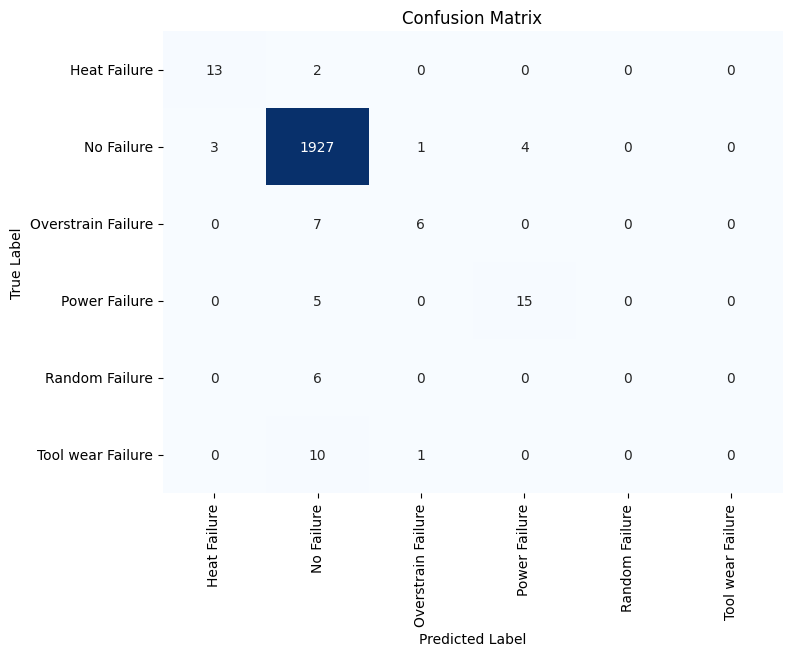

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=error_names, yticklabels=error_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Normalized confusion matrix

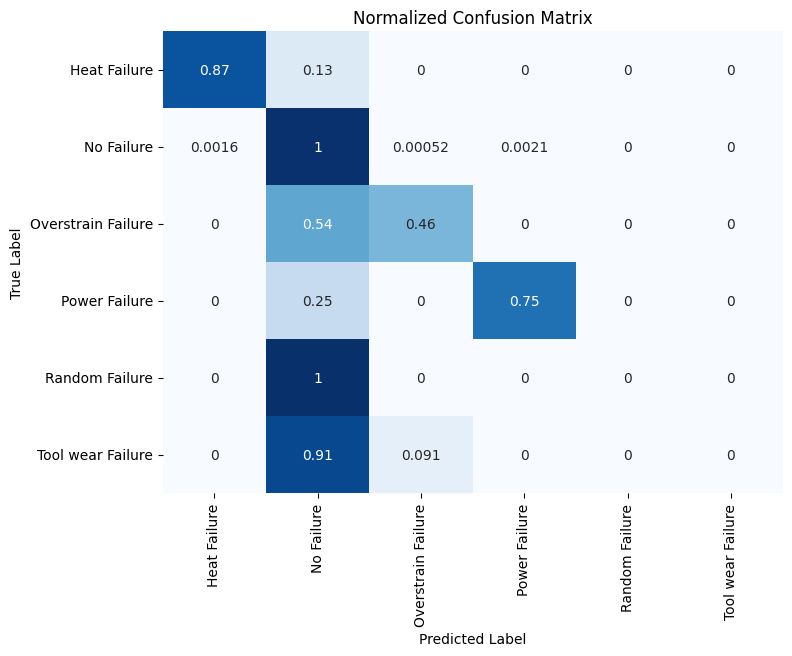

In [21]:
conf_matrix_normalized = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", cbar=False, xticklabels=error_names, yticklabels=error_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()
